# LDA Demonstration


In this notebook, we will build LDA models on various datasets. We'll use the gensim implementation of LDA, though sklearn also comes with one. 

We will also use the library spacy for preprocessing (specifically lemmatisation). Though you can also perform lemmatisation in NLTK, it is slightly more convenient and less verbose in spacy. For visualising the topics and the word-topic distributions (interactively!), we'll use the 'pyLDAvis' module.

In [113]:
# import libraries  
import numpy as np
import pandas as pd
import nltk
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns

# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Demonetisation Tweets

Let's now try identifying topics in tweets related to a specific topic - demonetisation. The overall pipeline is the same, apart from someextra preprocessing steps.

In [76]:
df = pd.read_csv("demonetization-tweets.csv", encoding = "ISO-8859-1")
print(df.shape)
df.head()

(14940, 16)


,Unnamed: 0,X,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted
0,1,1,RT @rssurjewala: Critical question: Was PayTM ...,False,0,NaN,2016-11-23 18:40:30,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",HASHTAGFARZIWAL,331,True,False
1,2,2,RT @Hemant_80: Did you vote on #Demonetization...,False,0,NaN,2016-11-23 18:40:29,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",PRAMODKAUSHIK9,66,True,False
2,3,3,"RT @roshankar: Former FinSec, RBI Dy Governor,...",False,0,NaN,2016-11-23 18:40:03,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",rahulja13034944,12,True,False
3,4,4,RT @ANI_news: Gurugram (Haryana): Post office ...,False,0,NaN,2016-11-23 18:39:59,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",deeptiyvd,338,True,False
4,5,5,RT @satishacharya: Reddy Wedding! @mail_today ...,False,0,NaN,2016-11-23 18:39:39,False,NaN,8.014954e+17,NaN,"<a href=""http://cpimharyana.com"" rel=""nofollow...",CPIMBadli,120,True,False


In [77]:
# see randomly chosen sample tweets
df.text[random.randrange(len(df.text))]

'RT @centerofright: #DeMonetization - Ppl are ready to give @narendramodi the 50 Days he asked for in the war against corruption and black m\x85'

In [78]:
df.text[:10]

0    RT @rssurjewala: Critical question: Was PayTM ...
1    RT @Hemant_80: Did you vote on #Demonetization...
2    RT @roshankar: Former FinSec, RBI Dy Governor,...
3    RT @ANI_news: Gurugram (Haryana): Post office ...
4    RT @satishacharya: Reddy Wedding! @mail_today ...
5    @DerekScissors1: Indias #demonetization: #Bla...
6    RT @gauravcsawant: Rs 40 lakh looted from a ba...
7    RT @Joydeep_911: Calling all Nationalists to j...
8    RT @sumitbhati2002: Many opposition leaders ar...
9    National reform now destroyed even the essence...
Name: text, dtype: object

Note that many tweets have strings such as RT, @xyz, etc. Some have URLs, punctuation marks, smileys etc. The following code cleans the data to handle many of these issues.

In [79]:
# remove URLs
def remove_URL(x):
            return x.replace(r'https[a-zA-Z0-9]*', "", regex = True)


# clean tweet text
def clean_tweets(tweet_col):
    
    df = pd.DataFrame({'tweet':tweet_col})
    
    df['tweet'] = df['tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
    df['tweet'] = df['tweet'].replace("  ", " ")
    df['tweet'] = df['tweet'].replace(r'@[a-zA-Z0-9]*', '', regex=True)
    df['tweet'] = remove_URL(df['tweet'])
    df['tweet'] = df['tweet'].str.lower() 
    
    return(df)

cleaned_tweets = clean_tweets(df.text)
cleaned_tweets[:10]

,tweet
0,rt : critical question: was paytm informed abo...
1,rt _80: did you vote on #demonetization on mod...
2,rt : former finsec rbi dy governor cbdt chair ...
3,rt _news: gurugram haryana: post office employ...
4,rt : reddy wedding! _today cartoon #demonetiza...
5,: indias #demonetization: #blackmoney a sympt...
6,rt : rs 40 lakh looted from a bank in kishtwar...
7,rt _911: calling all nationalists to join\rwal...
8,rt : many opposition leaders are with on the ...
9,national reform now destroyed even the essence...


Since tweets often contain slang words such as *wat, rt, lol* etc, we can append the stopwords with a list of such custom words and remove them.

In [80]:
words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there",
                    "all","we","one","the","a","an","of","or","in","for","by","on","but","is","in",
                    "a","not","with","as","was","if","they","are","this","and","it","have","from","at",
                    "my","be","by","not","that","to","from","com","org","like","likes","so","said","from",
                    "what","told","over","more","other","have","last","with","this","that","such","when",
                    "been","says","will","also","where","why","would","today", "in", "on", "you", "r", "d", 
                    "u", "hw","wat", "oly", "s", "b", "ht", "rt", "p","the","th", "lol", ':']


# remove stop words, punctuations 
stop_words = set(list(stopwords.words('english') + 
                      list(string.punctuation) +
                      words_remove)) 

data_words = list(sent_to_words(cleaned_tweets.tweet.values.tolist(), deacc=False))


# remove stopwords
def remove_stopwords(texts, stop_words=stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)


# spacy for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [81]:
# sample lemmatized tweets
data_lemmatized[:3]

[['critical',
  'question',
  'paytm',
  'inform',
  'demonetization',
  'edict',
  'pm',
  'clearly',
  'fishy',
  'require',
  'full',
  'disclosure',
  'amp'],
 ['vote', 'demonetization', 'modi', 'survey', 'app'],
 ['former',
  'finsec',
  'rbi',
  'governor',
  'cbdt',
  'chair',
  'harvard',
  'professor',
  'lambaste',
  'demonetization',
  'aadmi',
  'listen']]

In [82]:
# create dictionary and corpus
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [88]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

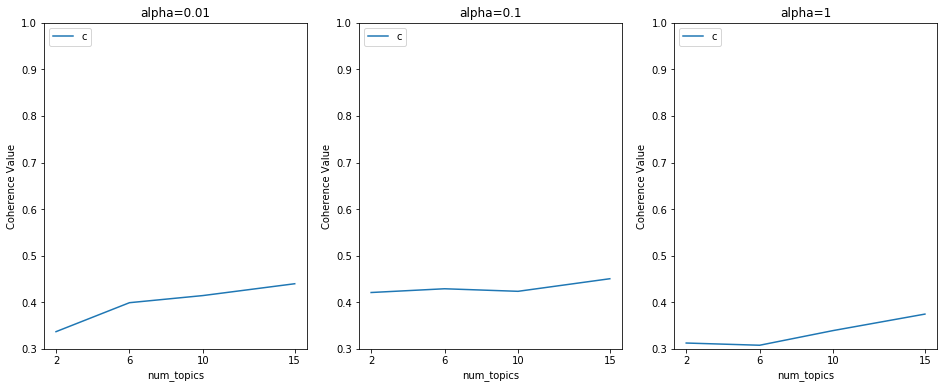

In [91]:
# plot
plot_coherence(coherence_df, alpha_range, num_topics_range)

In [92]:
# Build LDA model with alpha=0.1 and 10 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1,
                                           per_word_topics=True)

In [93]:
# print keywords 
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.098*"modi" + 0.088*"demonetization" + 0.066*"poor" + 0.062*"love" + '
  '0.062*"quiet" + 0.061*"men" + 0.061*"prohibition" + 0.061*"tobaccogutkha" + '
  '0.061*"engli" + 0.050*"implement"'),
 (1,
  '0.084*"demonetization" + 0.062*"youtube" + 0.059*"people" + 0.049*"economy" '
  '+ 0.027*"indian" + 0.026*"flag" + 0.026*"reinstate" + 0.025*"thus" + '
  '0.025*"ge" + 0.018*"back"'),
 (2,
  '0.185*"ed" + 0.081*"demonetization" + 0.063*"keep" + 0.038*"bc" + '
  '0.036*"bf" + 0.036*"headline" + 0.036*"yearend" + 0.033*"wave" + '
  '0.028*"index" + 0.028*"ad"'),
 (3,
  '0.112*"ban" + 0.091*"find" + 0.081*"demonetization" + 0.057*"economic" + '
  '0.045*"effect" + 0.043*"tcoe" + 0.028*"less" + 0.027*"system" + '
  '0.025*"double" + 0.024*"already"'),
 (4,
  '0.085*"demonetization" + 0.077*"pm" + 0.052*"due" + 0.050*"shortage" + '
  '0.048*"ufe" + 0.038*"question" + 0.036*"end" + 0.034*"parliament" + '
  '0.033*"coast" + 0.033*"fisherman"'),
 (5,
  '0.077*"cash" + 0.059*"demonetizatio

In [95]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4645754680906517


In [96]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      14.642657        1       1 -0.053408 -0.009416
7      13.439916        1       2  0.066220  0.004847
5      10.127769        1       3 -0.125509 -0.003342
6       9.871559        1       4 -0.117661  0.016894
0       9.829674        1       5  0.271932 -0.273334
1       9.506565        1       6 -0.090176 -0.014362
2       9.334724        1       7  0.228325  0.315480
9       8.173551        1       8 -0.071373 -0.005770
3       7.688958        1       9 -0.026028 -0.021636
8       7.384621        1      10 -0.082322 -0.009360, topic_info=     Category         Freq            Term         Total  loglift  logprob
term                                                                      
97    Default  2581.000000              ed   2581.000000  30.0000  30.0000
47    Default  2813.000000           india   2813.000000  29.0000  29.0000
593   Default  1397.000000            rich   1397.000000  28.0000  28.0000
14    Default  1437.000000            modi   1437.000000  27.0000  27.0000
214   Default  1286.000000             ban   1286.000000  26.0000  26.0000
10    Default  1678.000000              pm   1678.000000  25.0000  25.0000
123   Default  1179.000000            good   1179.000000  24.0000  24.0000
1146  Default  1049.000000            find   1049.000000  23.0000  23.0000
28    Default  1158.000000            cash   1158.000000  22.0000  22.0000
947   Default  1323.000000            will   1323.000000  21.0000  21.0000
2212  Default  1496.000000         youtube   1496.000000  20.0000  20.0000
206   Default   908.000000          result    908.000000  19.0000  19.0000
170   Default   961.000000            poor    961.000000  18.0000  18.0000
356   Default  1145.000000             due   1145.000000  17.0000  17.0000
1129  Default  1061.000000            dear   1061.000000  16.0000  16.0000
57    Default   915.000000               s    915.000000  15.0000  15.0000
2241  Default   911.000000            love    911.000000  14.0000  14.0000
2616  Default   902.000000           quiet    902.000000  13.0000  13.0000
907   Default   881.000000            keep    881.000000  12.0000  12.0000
330   Default  1089.000000        shortage   1089.000000  11.0000  11.0000
9475  Default   902.000000   tobaccogutkha    902.000000  10.0000  10.0000
9474  Default   902.000000     prohibition    902.000000   9.0000   9.0000
9473  Default   902.000000             men    902.000000   8.0000   8.0000
9472  Default   902.000000           engli    902.000000   7.0000   7.0000
604   Default   864.000000           staff    864.000000   6.0000   6.0000
6839  Default  1041.000000             ufe   1041.000000   5.0000   5.0000
2156  Default   995.000000        actually    995.000000   4.0000   4.0000
89    Default   837.000000          people    837.000000   3.0000   3.0000
6929  Default   843.000000            yogi    843.000000   2.0000   2.0000
8678  Default   833.000000      adityanath    833.000000   1.0000   1.0000
...       ...          ...             ...           ...      ...      ...
327   Topic10   265.359924             day    266.236145   2.6025  -3.7251
7896  Topic10   133.650345       diwasyoga    134.530945   2.5992  -4.4110
7897  Topic10   133.650345       drivesgau    134.530945   2.5992  -4.4110
7898  Topic10   133.650345     rakshaksetc    134.530945   2.5992  -4.4110
7899  Topic10   133.650345           stunt    134.530945   2.5992  -4.4110
7900  Topic10   133.650345        swachata    134.530945   2.5992  -4.4110
27    Topic10   119.601585             rbi    120.477890   2.5985  -4.5221
1832  Topic10    89.840126          update     90.716438   2.5961  -4.8082
663   Topic10    90.031380        surgical     90.914536   2.5960  -4.8061
9387  Topic10   505.797363      politicsit    511.246979   2.5951  -3.0801
9388  Topic10   505.797363     transparent    511.246979   2.5951  -3.0801
193   Top